# Hourly Electricity Consumption Data Analysis and Building an ARIMA Model

The data is publicly provided in this [link](https://seffaflik.epias.com.tr/transparency/tuketim/gerceklesen-tuketim/gercek-zamanli-tuketim.xhtml). The data consist of hourly electricity consumptions from 1st of January, 2016 to 20th of May, 2021. The aim of this assignment is analysing the properties of electricity consumption data and building and comparing different models. Then we'll predict tomorrow’s hourly electricity consumption of Turkey. 
 
Firstly, the possible types of seasonality will be decomposed and analysed. Then, we'll use a specific time frequency in order to build AR, MA, and ARIMA models. Lastly, the models will be compared in terms of AIC values.

## Required Packages & Data Preparation

In [46]:
options(warn=-1) #hiding the warning messages
library(data.table)
library(ggplot2)
library(zoo)
library(lubridate)
library(tsibble)
library(urca)
library(forecast)

In [2]:
dt <- fread("HW3_dataRealTimeConsumption.csv")
dt[, `:=`(datetime=as.POSIXct(paste(dt$Date, dt$Hour), format="%d.%m.%Y %H:%M"),
         Date=as.Date(dt$Date, format="%d.%m.%Y"),
         Consumption=as.numeric(sub(",", "", dt$Consumption)))]
test_set <- dt[Date>="2021-05-06"]
dt <- dt[Date<"2021-05-06"]


str(dt)
summary(dt[,3])
head(dt)

Classes 'data.table' and 'data.frame':	46848 obs. of  4 variables:
 $ Date       : Date, format: "2016-01-01" "2016-01-01" ...
 $ Hour       : chr  "0:00" "1:00" "2:00" "3:00" ...
 $ Consumption: num  26277 24992 23533 22465 22003 ...
 $ datetime   : POSIXct, format: "2016-01-01 00:00:00" "2016-01-01 01:00:00" ...
 - attr(*, ".internal.selfref")=<externalptr> 


  Consumption   
 Min.   :    0  
 1st Qu.:29062  
 Median :33112  
 Mean   :33018  
 3rd Qu.:36685  
 Max.   :49342  

Date,Hour,Consumption,datetime
2016-01-01,0:00,26277.24,2016-01-01 00:00:00
2016-01-01,1:00,24991.82,2016-01-01 01:00:00
2016-01-01,2:00,23532.61,2016-01-01 02:00:00
2016-01-01,3:00,22464.78,2016-01-01 03:00:00
2016-01-01,4:00,22002.91,2016-01-01 04:00:00
2016-01-01,5:00,21957.08,2016-01-01 05:00:00


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


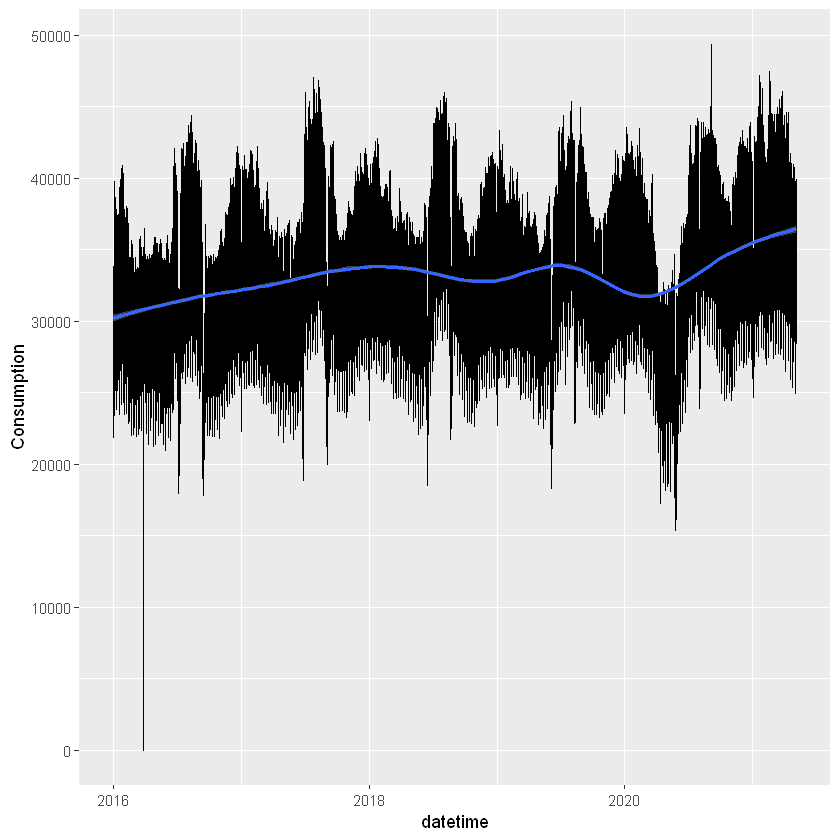

In [3]:
ggplot(dt, aes(x=datetime, y=Consumption)) + geom_line() + geom_smooth()

* In summers, the electricity consumption is higher than the other seasons. Also, consumptions in winter are higher than fall and spring terms. 
* Generally, it seems that there is an increasing trend by the blue line. 
* The decrease in the consumption from the early 2020 to the middle of 2020 is due to the lock downs. After, the consumption pattern continues like before.
* There are some unusual jumping and falling points in every year because of the special days like national or religios holidays.  
* It appears that the data is not stationary. In the next steps, it will be analysed and decomposed.
* The variance seems to be constant over time. Therefore, additive composition will be used later.
* Lastly, there is an outlier point in the beginning of 2016. The consumption is given as zero. It will be replaced by the average of the one day before and after in the same hour.

In [4]:
dt[dt$Consumption==0]$datetime #finding the date when the consumption is zero

[1] "2016-03-27 02:00:00 EET"

In [5]:
dt[dt$Consumption==0]$Consumption <- (dt[datetime=="2016-03-26 02:00:00 EET"]$Consumption+
                          dt[datetime=="2016-03-28 02:00:00 EET"]$Consumption)/2
summary(dt[,3])

  Consumption   
 Min.   :15333  
 1st Qu.:29062  
 Median :33112  
 Mean   :33019  
 3rd Qu.:36685  
 Max.   :49342  

## Decomposing the Data at Different Levels  

### Hourly Decomposing

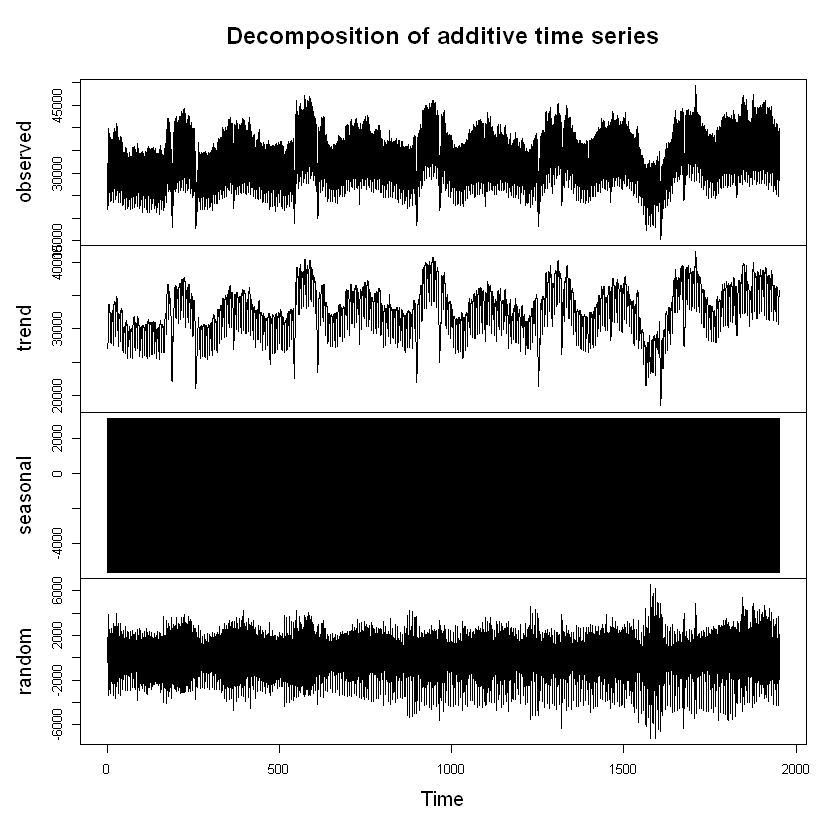

In [6]:
#in all the steps below, additive decomposition will be used due to the constant variance over time as mentioned above. 
dt_hourly_dec <- decompose(ts(dt$Consumption, freq=24), type="additive")
plot(dt_hourly_dec)

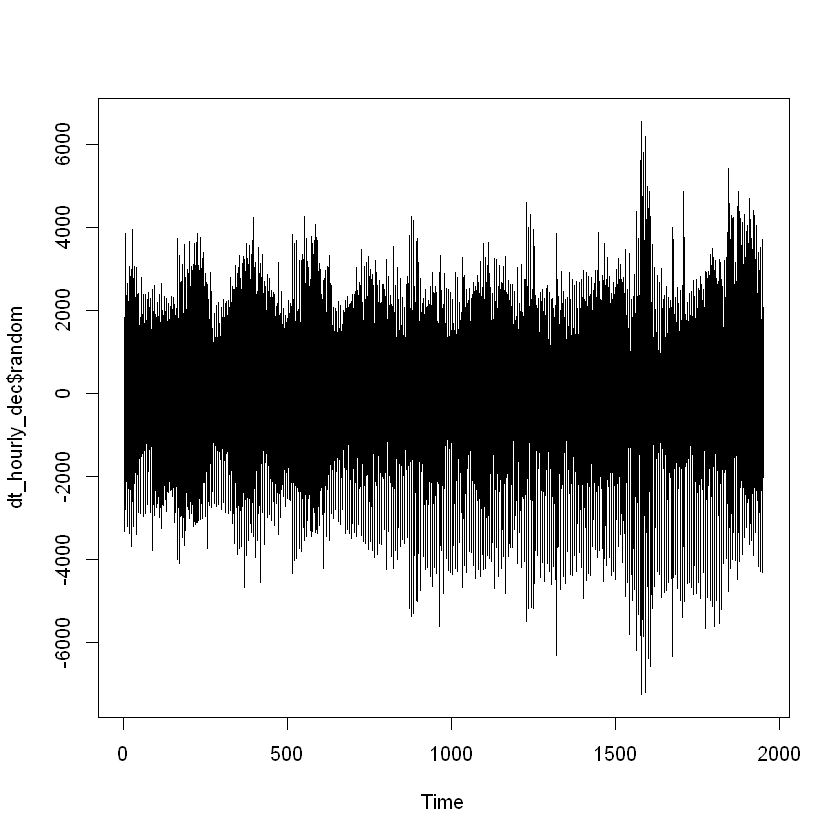

In [7]:
plot(dt_hourly_dec$random)

* The variance is slightly increasing over time.
* The mean seems to be constant over time. 

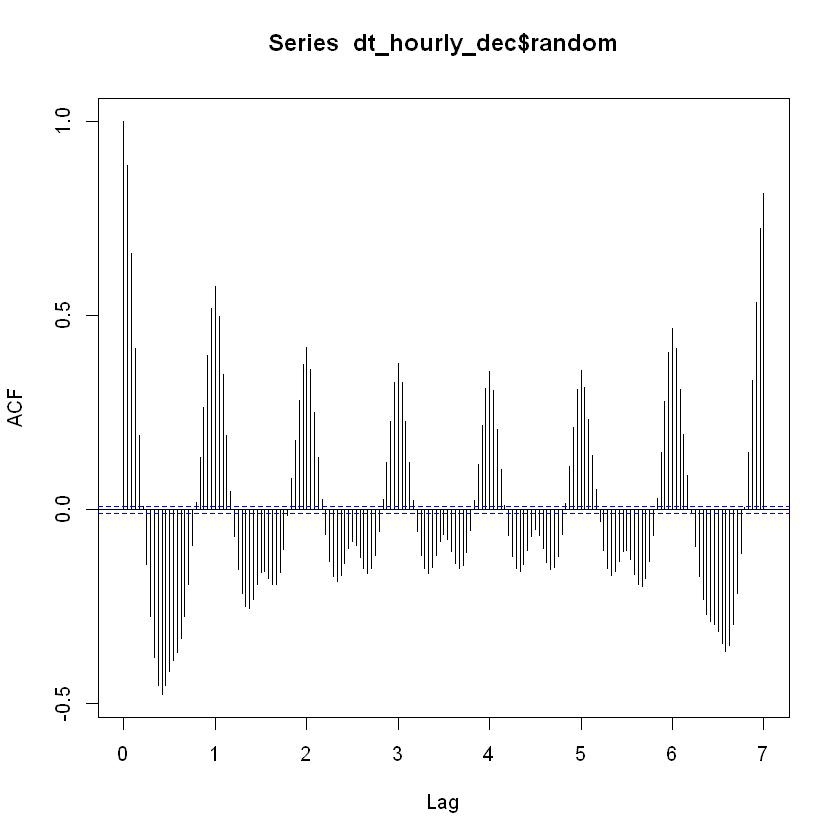

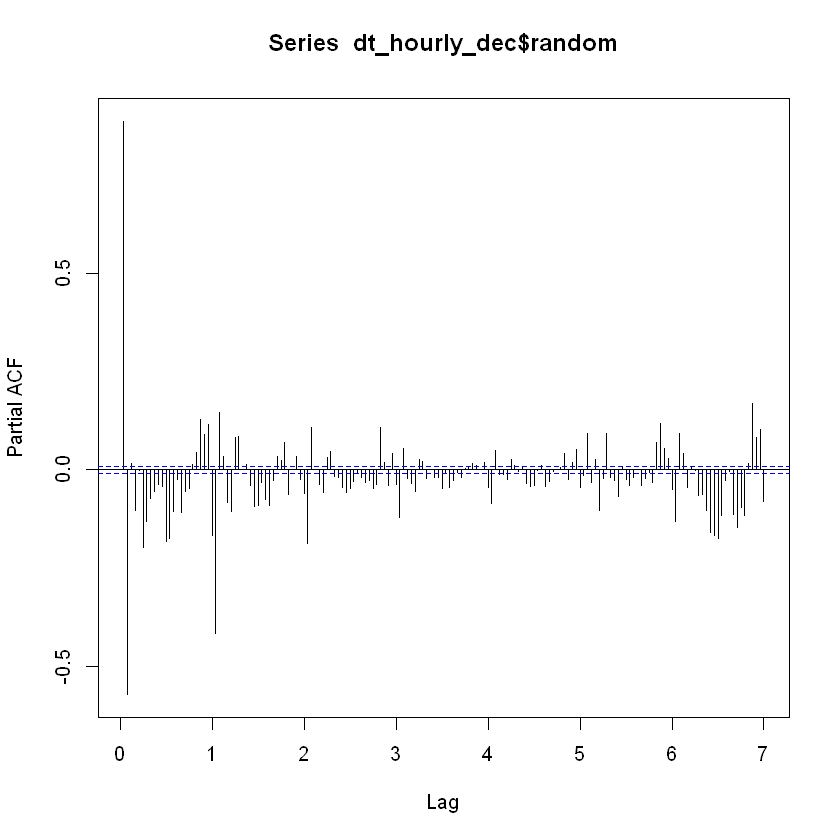

In [8]:
acf(dt_hourly_dec$random, na.action=na.pass, lag=24*7)
pacf(dt_hourly_dec$random, na.action=na.pass, lag=24*7)

From ACF, we see that there are still daily and weekly seasonalities. Also, from PACF, there are high correlation in the integer lags, which corresponds to the days. Let's check the unit test. 

In [9]:
u_test <- ur.kpss(dt_hourly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 18 lags. 

Value of test-statistic is: 3e-04 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


The test statistics is much lower than the critical values, which means that there is not enough evidence to reject the null hyphothesis. But from the ACF and PACF, we know that there is still seasonality effect. 

### Daily Decomposing

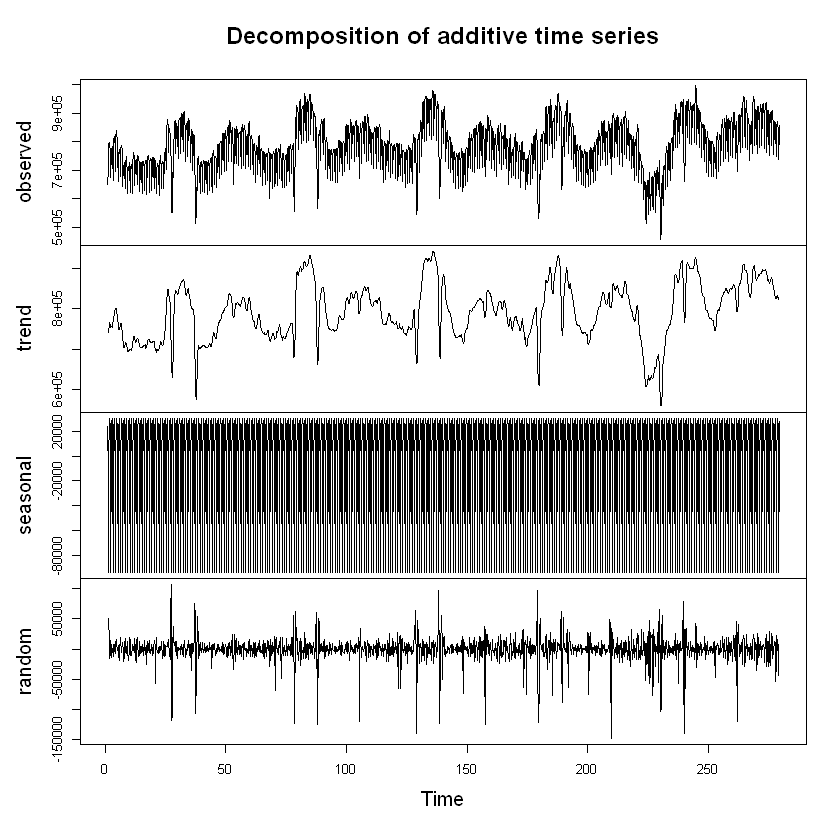

In [10]:
#preparing daily data by summing hourly observations
dt_daily <- dt[, .(Consumption=sum(Consumption)), by=Date]
dt_daily_dec <- decompose(ts(dt_daily$Consumption, freq=7))
plot(dt_daily_dec)

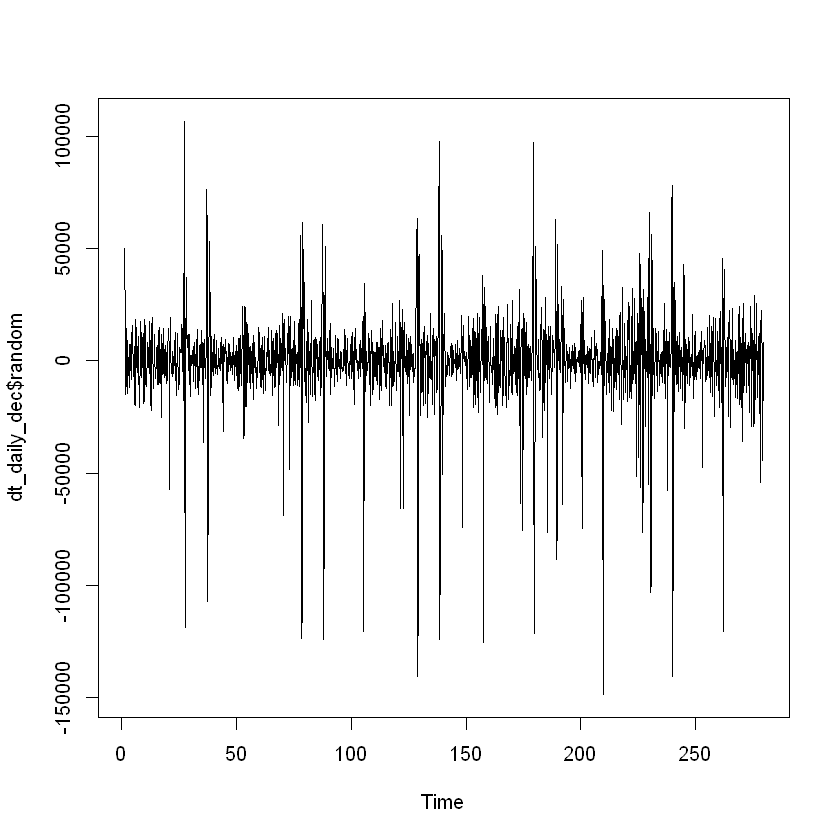

In [11]:
plot(dt_daily_dec$random)

* The variance is high at the beginning, then it slightly increases over time.
* The mean seems to be constant over time.
* There is an extremely falling point, which may cause a problem. 

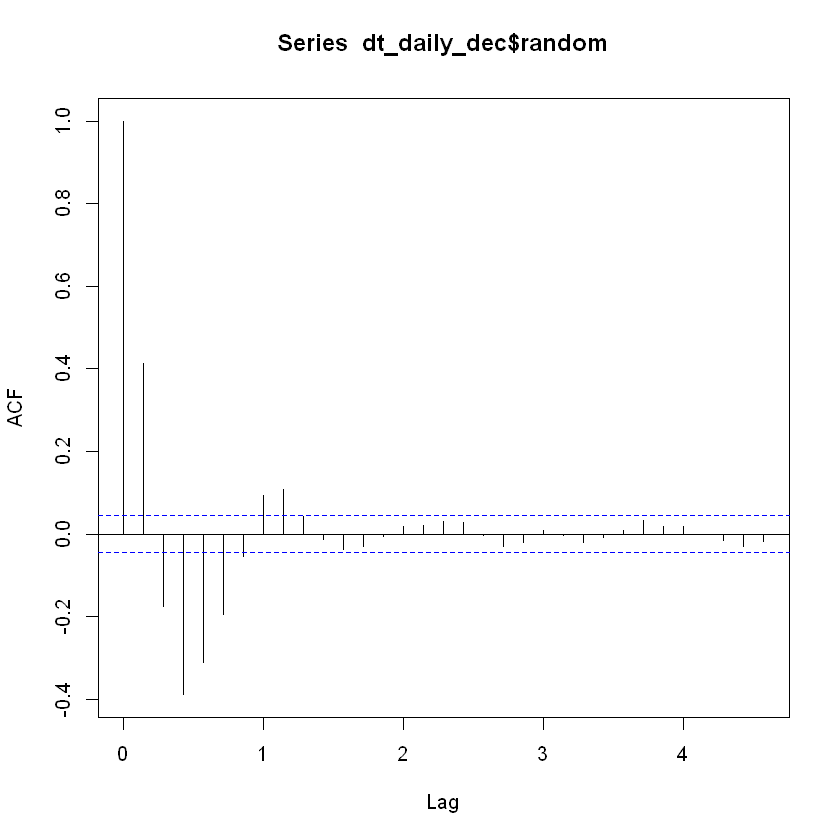

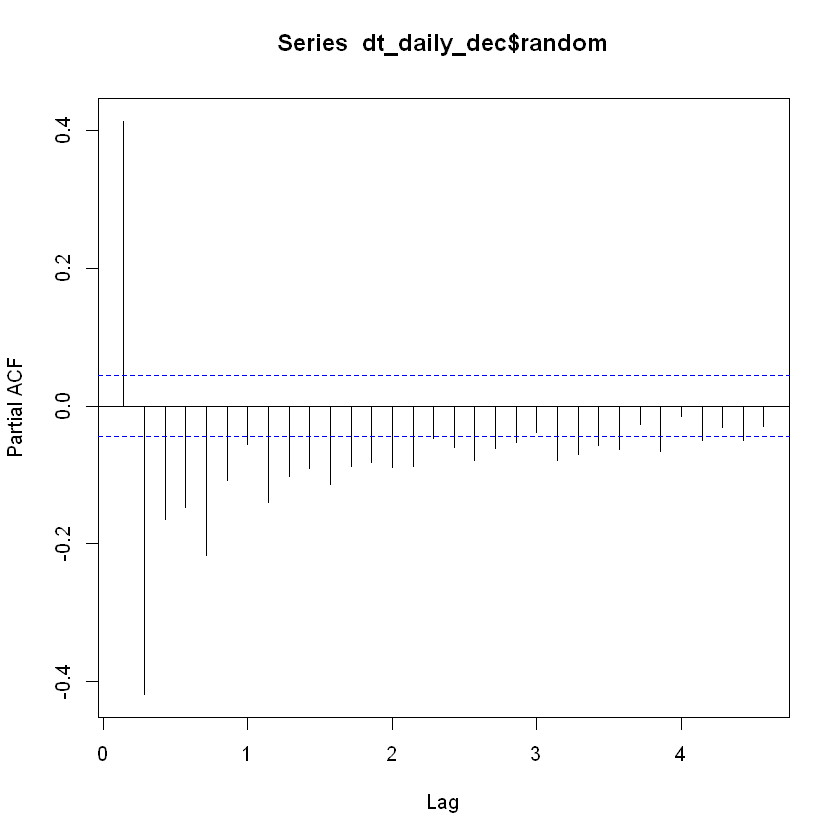

In [12]:
acf(dt_daily_dec$random, na.action = na.pass)
pacf(dt_daily_dec$random, na.action = na.pass)

From ACF, we see that every week there is an autocorrelation. Also from PACF, it seems that there is still trend component in data.  

In [13]:
u_test <- ur.kpss(dt_daily_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 8 lags. 

Value of test-statistic is: 0.0046 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


The test statistics is lower than the critical values, which means that the data is stationary. But from the ACF and PACF, we know that there are still weekly seasonality and trend components. 

### Weekly Decomposing

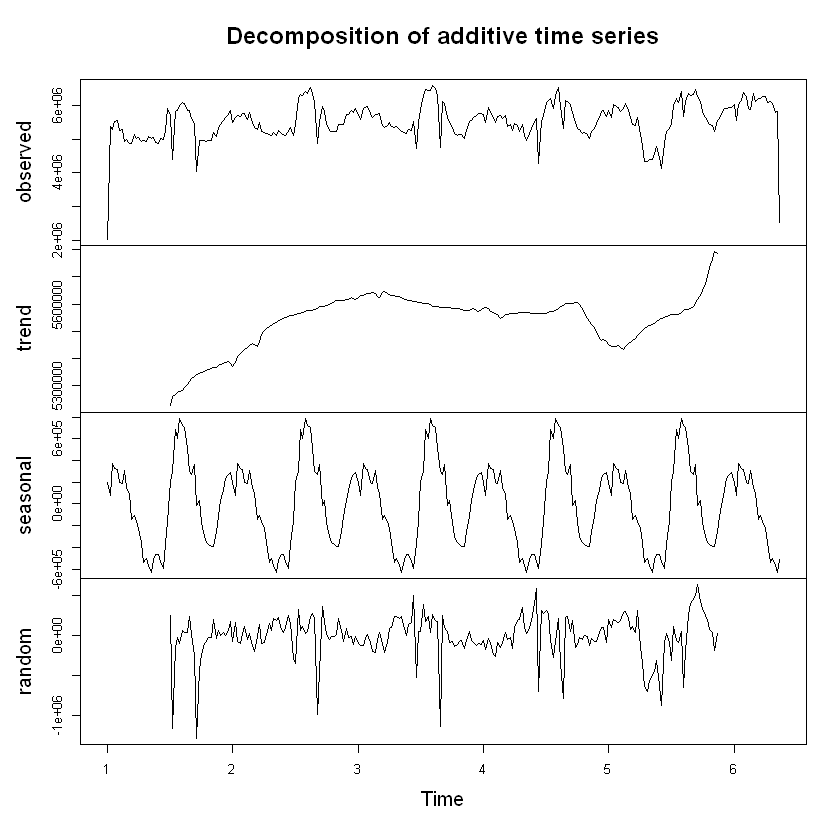

In [14]:
#preparing weekly data by summing observations
dt_weekly <- dt_daily[, week:=yearweek(Date)]
dt_weekly <- dt_weekly[, .(Consumption=sum(Consumption)), by=week]
dt_weekly_dec <- decompose(ts(dt_weekly$Consumption, freq=52))
plot(dt_weekly_dec)

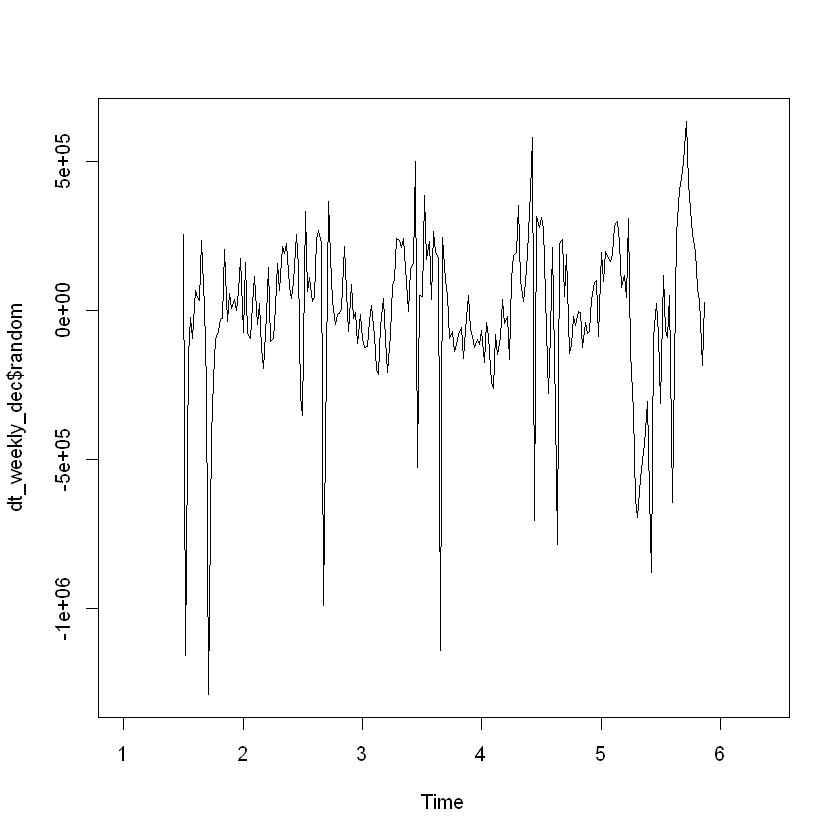

In [15]:
plot(dt_weekly_dec$random)

* The variance changes over time. Some preprocesses mey be required.
* The mean is not constant over time. 

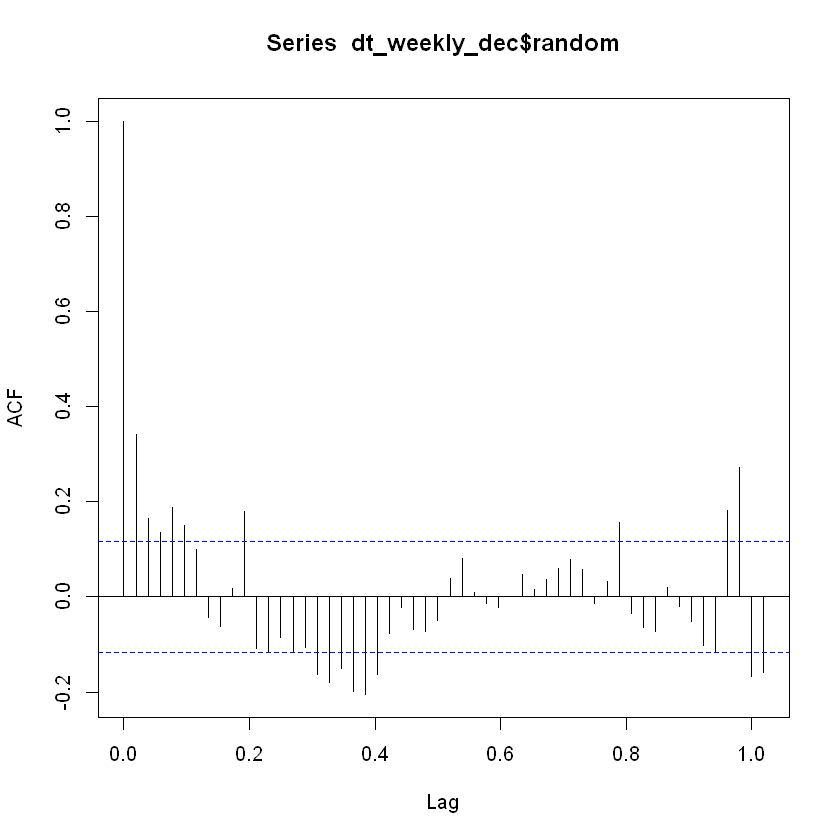

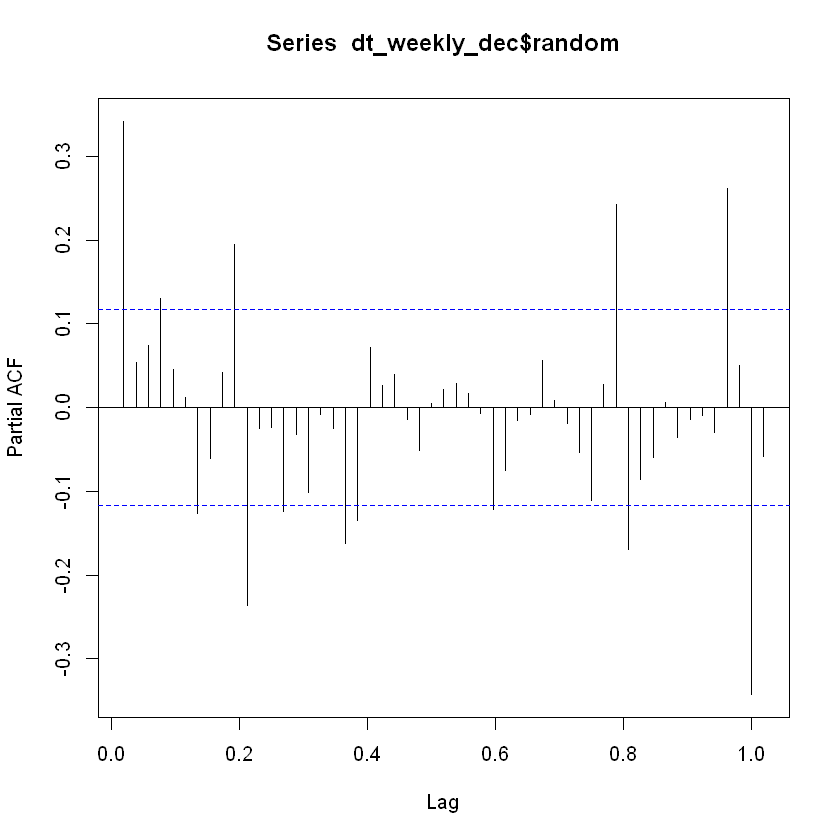

In [16]:
acf(dt_weekly_dec$random, na.action=na.pass, lag=53)
pacf(dt_weekly_dec$random, na.action=na.pass, lag=53)

There is not a high autocorrelation value. But, the slight correlation with every ten week can be seen from the graphs.

In [17]:
u_test <- ur.kpss(dt_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 4 lags. 

Value of test-statistic is: 0.0704 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


The null hyphotesis is not rejected, which means that the data is stationary.

### Monthly Decomposing

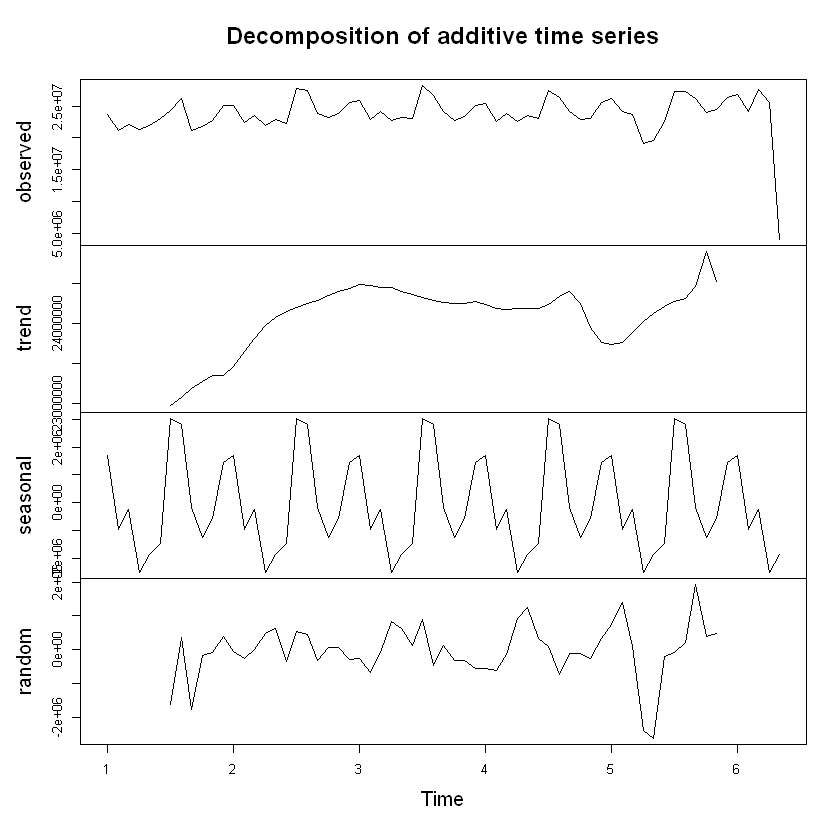

In [18]:
#preparing monthly data by summing observations
dt_monthly <- dt[, month:=yearmonth(Date)]
dt_monthly <- dt_monthly[, .(Consumption=sum(Consumption)), by=month]
dt_monthly_dec <- decompose(ts(dt_monthly$Consumption, freq=12))
plot(dt_monthly_dec)

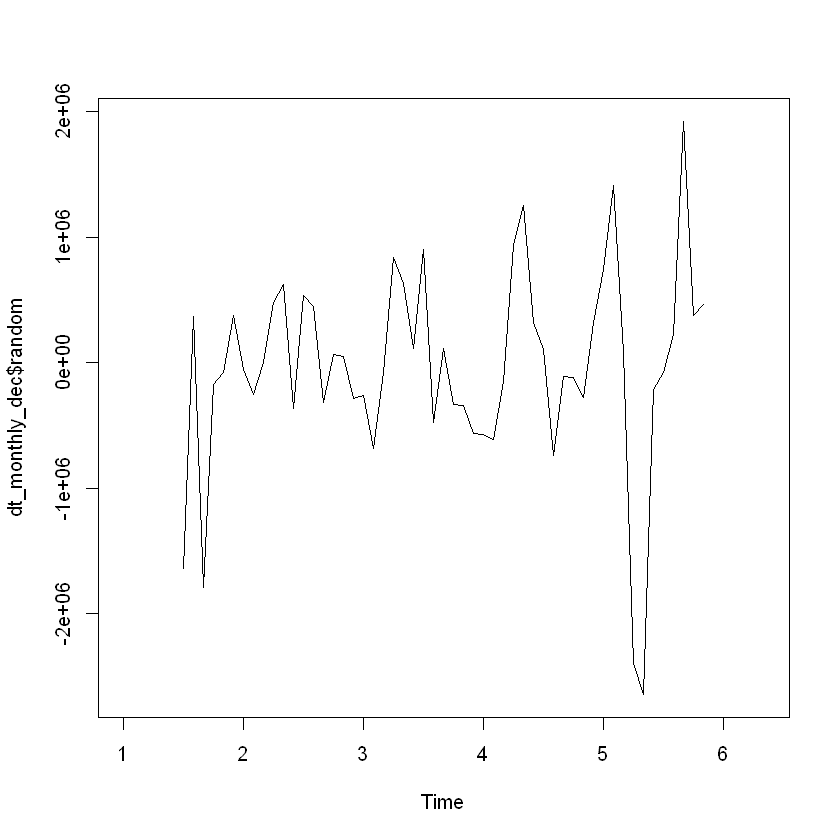

In [19]:
plot(dt_monthly_dec$random)

Both mean and variance are not constant over time. 

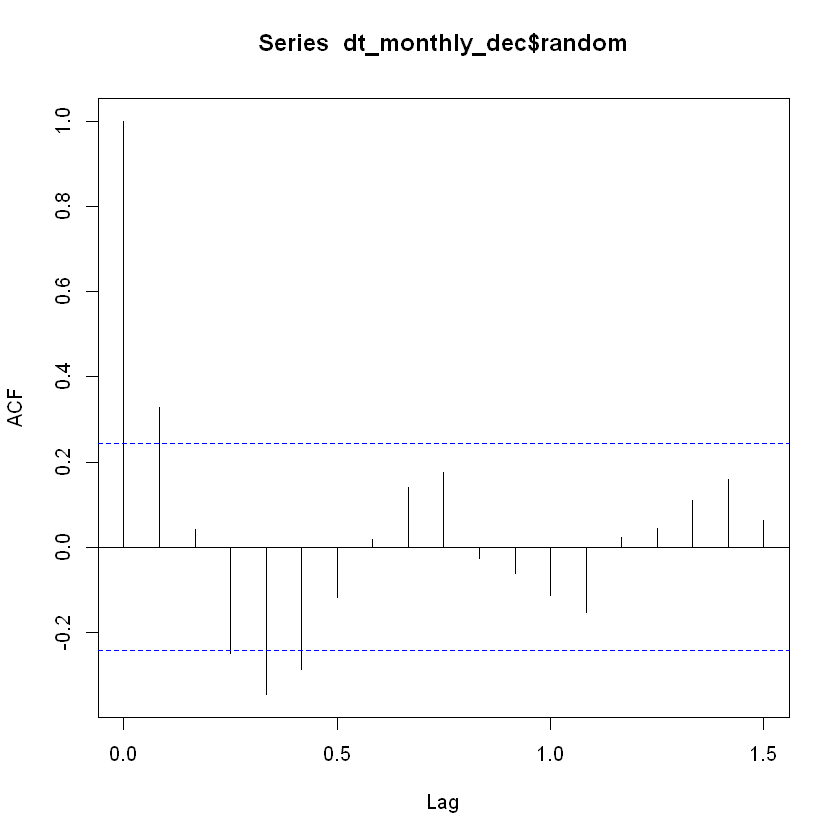

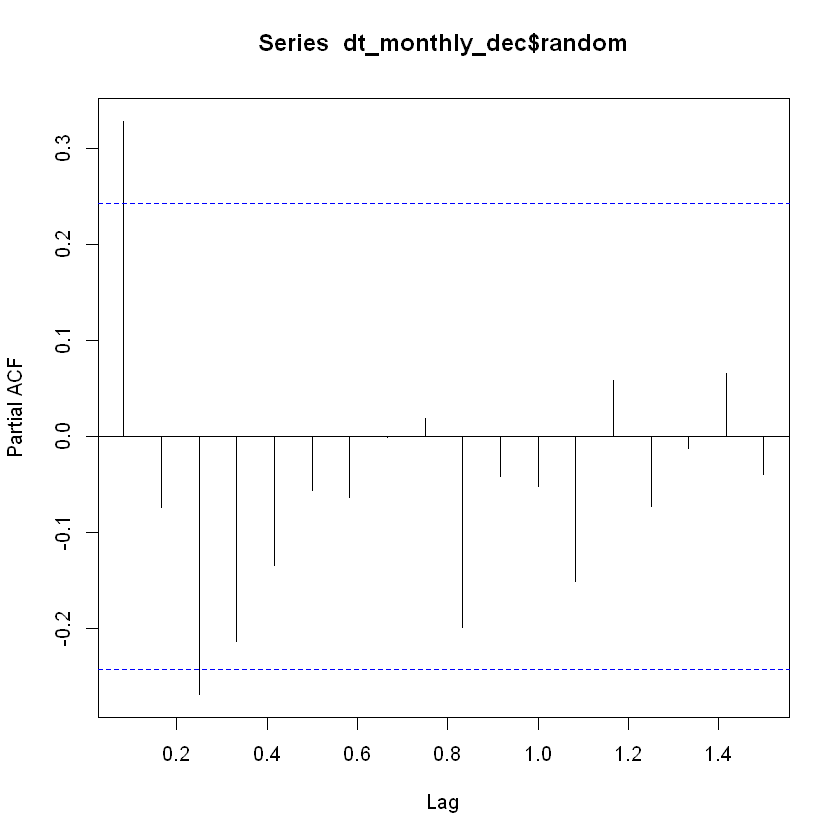

In [20]:
acf(dt_monthly_dec$random, na.action=na.pass)
pacf(dt_monthly_dec$random, na.action=na.pass)

There is not a significant autocorrelation value.

In [21]:
u_test <- ur.kpss(dt_monthly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.0641 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Because the test statistics is again below the critical values, we do not reject the null hyphothesis.

## Deseasonalizing and Detrending the Series | AR Model

We are supposing that there is a pattern at every 168 hours. Therefore, the coming steps will rely on that assumption.

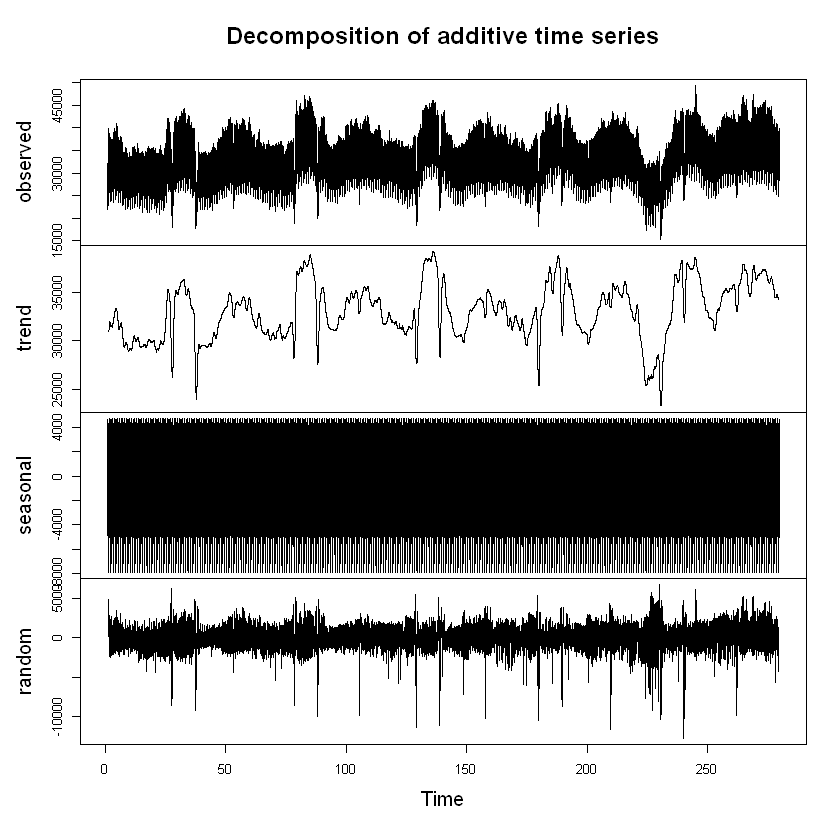

In [22]:
#again, we use additive decomposition because of the constant variance.
dt_decomposed <- decompose(ts(dt$Consumption, freq=24*7), type="additive")
plot(dt_decomposed)

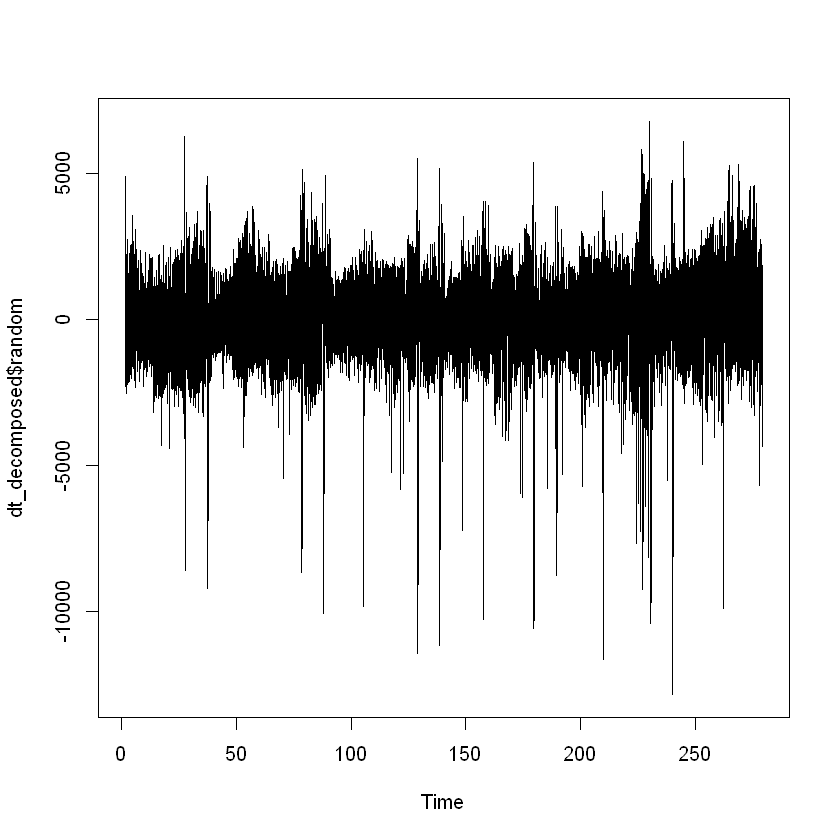

In [23]:
plot(dt_decomposed$random)

The mean and variance seem to be constant over time. There are some jumping and falling points. Let's apply the unit test to check whether the data is stationary or not.

In [24]:
u_test <- ur.kpss(dt_decomposed$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 18 lags. 

Value of test-statistic is: 0.002 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


There is not enough evidence against the null hyphothesis, therefore we can use the data to build the models.

### AR Models

First, we start with p=1. Then we will increase p by one unit until AIC stops decreasing.

In [25]:
ARmodel1 <- arima(dt_decomposed$random, order=c(1,0,0))
ARmodel1


Call:
arima(x = dt_decomposed$random, order = c(1, 0, 0))

Coefficients:
         ar1  intercept
      0.9224    -0.2047
s.e.  0.0018    33.8074

sigma^2 estimated as 320566:  log likelihood = -362137.9,  aic = 724281.7

AIC is 724281.7, p is incremented.

In [26]:
ARmodel2 <- arima(dt_decomposed$random, order=c(2,0,0))
ARmodel2


Call:
arima(x = dt_decomposed$random, order = c(2, 0, 0))

Coefficients:
         ar1      ar2  intercept
      1.4036  -0.5217    -0.2054
s.e.  0.0039   0.0040    18.9347

sigma^2 estimated as 233342:  log likelihood = -354725.8,  aic = 709459.7

AIC decreases to 709459.7, p is incremented.

In [27]:
ARmodel3 <- arima(dt_decomposed$random, order=c(3,0,0))
ARmodel3


Call:
arima(x = dt_decomposed$random, order = c(3, 0, 0))

Coefficients:
         ar1      ar2     ar3  intercept
      1.4334  -0.6018  0.0571    -0.2055
s.e.  0.0046   0.0076  0.0046    20.0523

sigma^2 estimated as 232581:  log likelihood = -354649.5,  aic = 709309.1

AIC decreases to 709309.1, p is incremented.

In [28]:
ARmodel4 <- arima(dt_decomposed$random, order=c(4,0,0))
ARmodel4


Call:
arima(x = dt_decomposed$random, order = c(4, 0, 0))

Coefficients:
         ar1      ar2     ar3      ar4  intercept
      1.4366  -0.6362  0.1389  -0.0571    -0.2051
s.e.  0.0046   0.0081  0.0081   0.0046    18.9290

sigma^2 estimated as 231823:  log likelihood = -354573.4,  aic = 709158.8

AIC slightly decreases to 709158.8, but in order to prevent the increase of the model complexity, we stop at p=4. 

## Deseasonalizing and Detrending the Series | MA Model

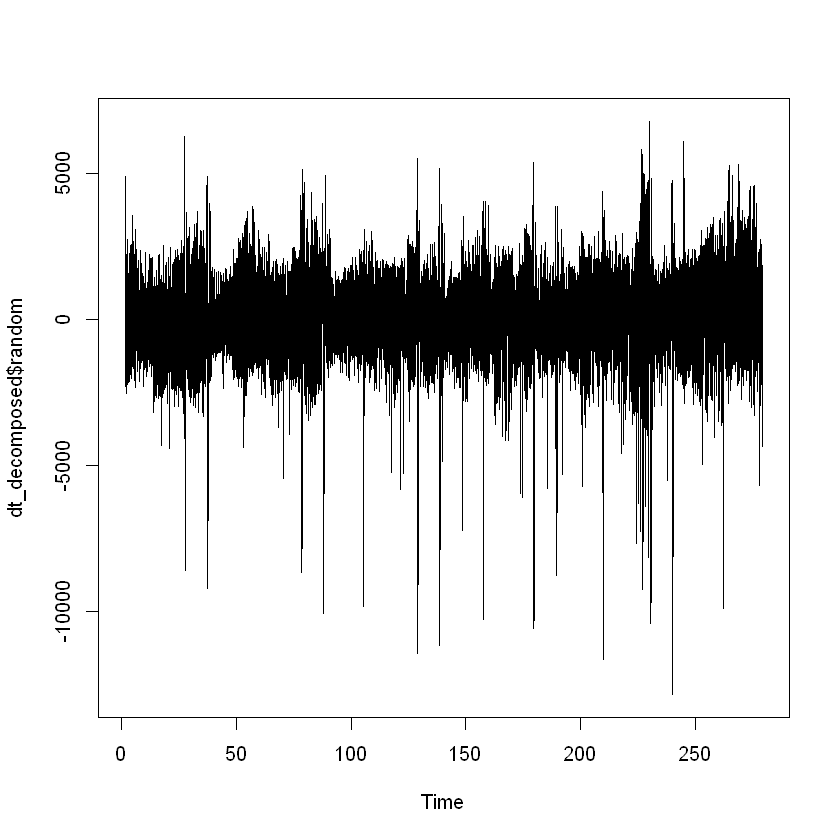

In [29]:
plot(dt_decomposed$random)

First, we start with q=1. Then we will increase q by one unit until AIC stops decreasing.

In [30]:
MAmodel1 <- arima(dt_decomposed$random, order=c(0,0,1))
MAmodel1


Call:
arima(x = dt_decomposed$random, order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.8845    -0.2061
s.e.  0.0015     7.3889

sigma^2 estimated as 717733:  log likelihood = -380949.9,  aic = 761905.9

AIC is 761905.9, q is incremented.

In [31]:
MAmodel2 <- arima(dt_decomposed$random, order=c(0,0,2))
MAmodel2


Call:
arima(x = dt_decomposed$random, order = c(0, 0, 2))

Coefficients:
         ma1     ma2  intercept
      1.2865  0.6529    -0.2059
s.e.  0.0033  0.0030     8.6725

sigma^2 estimated as 406422:  log likelihood = -367676.6,  aic = 735361.2

AIC decreases to 735361.2, p is incremented.

In [32]:
MAmodel3 <- arima(dt_decomposed$random, order=c(0,0,3))
MAmodel3


Call:
arima(x = dt_decomposed$random, order = c(0, 0, 3))

Coefficients:
         ma1     ma2     ma3  intercept
      1.3863  1.0893  0.5068    -0.2052
s.e.  0.0041  0.0047  0.0035    10.1411

sigma^2 estimated as 302712:  log likelihood = -360800.6,  aic = 721611.1

AIC decreases to 721611.1, p is incremented.

In [33]:
MAmodel4 <- arima(dt_decomposed$random, order=c(0,0,4))
MAmodel4


Call:
arima(x = dt_decomposed$random, order = c(0, 0, 4))

Coefficients:
         ma1     ma2     ma3     ma4  intercept
      1.4370  1.2822  0.8449  0.3219    -0.2052
s.e.  0.0047  0.0069  0.0055  0.0037    11.6671

sigma^2 estimated as 266188:  log likelihood = -357799.5,  aic = 715611

AIC slightly decreases to 715611, but in order to prevent the increase of the model complexity, we stop at q=4.

## Comparing the Results and ARMA Model

ARmodel4 with p=4 has AIC value of 709158.8 and MAmodel4 with q=4 has AIC value of 715611. We stopped at the p and q values of 4 because we dont want a complex model. 
 
Although they are really close to each other, ARmodel4 has smaller AIC value. 
 
Now, let's build an ARMA model with p=q=4. Then, the p and q values are increased or decreased at each step to find the min AIC value.

In [34]:
ARMAmodel1 <- arima(dt_decomposed$random, order=c(4,0,4))
ARMAmodel1

Warning message in arima(dt_decomposed$random, order = c(4, 0, 4)):
"possible convergence problem: optim gave code = 1"


Call:
arima(x = dt_decomposed$random, order = c(4, 0, 4))

Coefficients:
         ar1     ar2     ar3      ar4     ma1     ma2      ma3      ma4
      0.1266  0.5374  0.6394  -0.6151  1.3229  0.7262  -0.2860  -0.1593
s.e.  0.0110  0.0064  0.0027   0.0097  0.0123  0.0244   0.0235   0.0091
      intercept
        -0.1412
s.e.    18.3386

sigma^2 estimated as 225165:  log likelihood = -353893.5,  aic = 707807.1

In [35]:
ARMAmodel2 <- arima(dt_decomposed$random, order=c(4,0,3))
ARMAmodel2


Call:
arima(x = dt_decomposed$random, order = c(4, 0, 3))

Coefficients:
         ar1     ar2      ar3      ar4     ma1     ma2      ma3  intercept
      0.6355  0.4193  -0.1887  -0.0827  0.8027  0.0935  -0.0296    -0.1544
s.e.  0.2677  0.1709   0.1085   0.0803  0.2673  0.2096   0.0161    19.1941

sigma^2 estimated as 231594:  log likelihood = -354550.3,  aic = 709118.6

In [36]:
ARMAmodel3 <- arima(dt_decomposed$random, order=c(3,0,4))
ARMAmodel3


Call:
arima(x = dt_decomposed$random, order = c(3, 0, 4))

Coefficients:
         ar1     ar2      ar3     ma1      ma2      ma3      ma4  intercept
      0.7194  0.5701  -0.4568  0.7201  -0.1782  -0.1035  -0.0263     -0.098
s.e.  0.0309  0.0326   0.0169  0.0312   0.0281   0.0163   0.0075     18.786

sigma^2 estimated as 231241:  log likelihood = -354514.7,  aic = 709047.3

In [37]:
ARMAmodel4 <- arima(dt_decomposed$random, order=c(3,0,3))
ARMAmodel4


Call:
arima(x = dt_decomposed$random, order = c(3, 0, 3))

Coefficients:
         ar1     ar2      ar3     ma1      ma2      ma3  intercept
      0.6476  0.6117  -0.4484  0.7908  -0.1182  -0.0618    -0.1090
s.e.  0.0216  0.0260   0.0164  0.0224   0.0244   0.0111    18.9643

sigma^2 estimated as 231281:  log likelihood = -354518.8,  aic = 709053.6

In [38]:
ARMAmodel5 <- arima(dt_decomposed$random, order=c(2,0,4))
ARMAmodel5

Warning message in arima(dt_decomposed$random, order = c(2, 0, 4)):
"possible convergence problem: optim gave code = 1"


Call:
arima(x = dt_decomposed$random, order = c(2, 0, 4))

Coefficients:
         ar1      ar2      ma1      ma2     ma3     ma4  intercept
      1.4402  -0.5479  -0.0019  -0.0973  0.0141  0.0055     0.0924
s.e.  0.0259   0.0207   0.0263   0.0173  0.0091  0.0068    19.0282

sigma^2 estimated as 231715:  log likelihood = -354562.5,  aic = 709140.9

In [39]:
ARMAmodel6 <- arima(dt_decomposed$random, order=c(4,0,2))
ARMAmodel6


Call:
arima(x = dt_decomposed$random, order = c(4, 0, 2))

Coefficients:
         ar1     ar2      ar3      ar4     ma1     ma2  intercept
      0.4680  0.6399  -0.2988  -0.0465  0.9729  0.1216    -0.1340
s.e.  0.5174  0.3289   0.2637   0.1799  0.5202  0.4162    19.6293

sigma^2 estimated as 231382:  log likelihood = -354528.9,  aic = 709073.8

We tried to fit 6 models. ARMA(4,4) has the minimun value of AIC which is 707814.2. Also, it has the lowest AIC value between AR(4) and MA(4). Therefore, ARMAmodel1 will be used for the remaining steps.

In [40]:
fitted <- dt_decomposed$random - ARMAmodel1$residuals
transformed <- as.numeric(fitted) + as.numeric(dt_decomposed$seasonal) + as.numeric(dt_decomposed$trend)

In [41]:
dt[, `:=`(residuals=residuals(ARMAmodel1),
         fitted=transformed)]
tail(dt[!is.na(dt$fitted)])

Date,Hour,Consumption,datetime,month,residuals,fitted
2021-05-02,6:00,24905.73,2021-05-02 06:00:00,2021 May,-611.9532,25517.68
2021-05-02,7:00,25203.30,2021-05-02 07:00:00,2021 May,925.0741,24278.23
2021-05-02,8:00,26633.61,2021-05-02 08:00:00,2021 May,369.8859,26263.72
2021-05-02,9:00,27941.94,2021-05-02 09:00:00,2021 May,-273.9410,28215.88
2021-05-02,10:00,29418.61,2021-05-02 10:00:00,2021 May,109.4345,29309.18
2021-05-02,11:00,30763.09,2021-05-02 11:00:00,2021 May,454.2117,30308.88


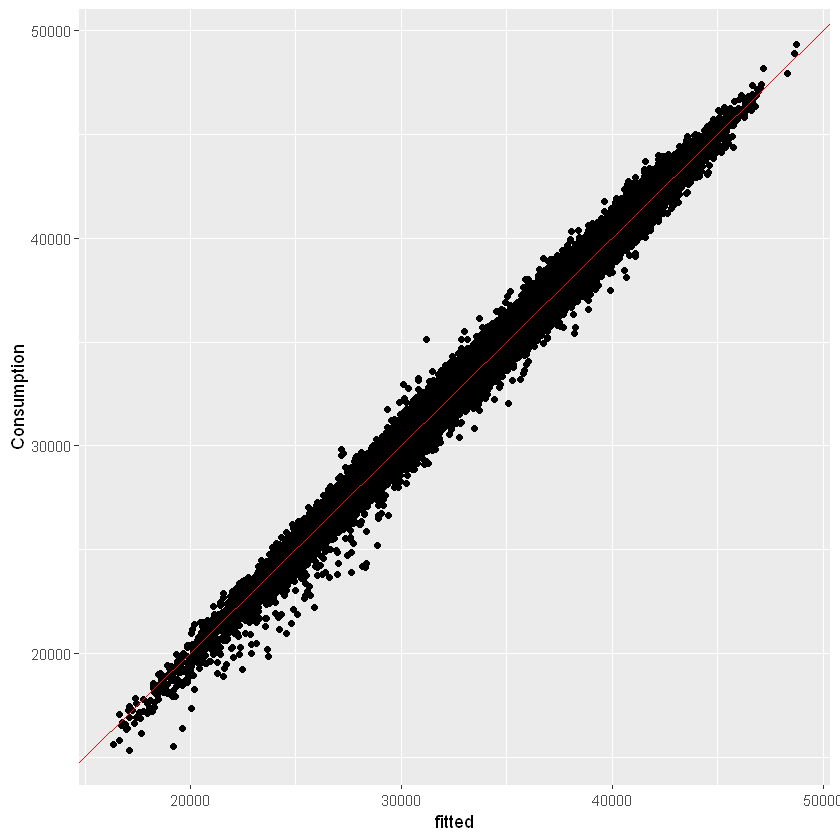

In [42]:
ggplot(dt[!is.na(dt$fitted)], aes(x=fitted, y=Consumption)) + geom_point() + geom_abline(intercept=0, slope=1, color="red")

fitted vs Consumption observations are very close to x=y line. Now, let's forecast the next 15 days.

## Forecast and Evaluation

* From the beginning of 6th May to the end of 20th May, there are 15 days. Therefore n.ahead is determined as 24*15.
* As trend component, we use the last trend from the decomposition.
* As seasonality component, we start with 145 because 2016-01-01 is friday and 2021-05-06 is thursday. There are 6 days of week, so I use 6*24+1 as a starting point. Then, I add 360 to it for ending point.

In [43]:
forecast_random <- predict(ARMAmodel1, n.ahead=24*15)$pred
forecast_trend <- tail(dt_decomposed$trend[!is.na(dt_decomposed$trend)],1)
forecast_seasonality <- dt_decomposed$seasonal[145:504]

model_forecast <- as.numeric(forecast_random) + as.numeric(forecast_trend) + as.numeric(forecast_seasonality)
test_set[, forecast:=model_forecast]
test_set[, residuals:=Consumption-forecast]

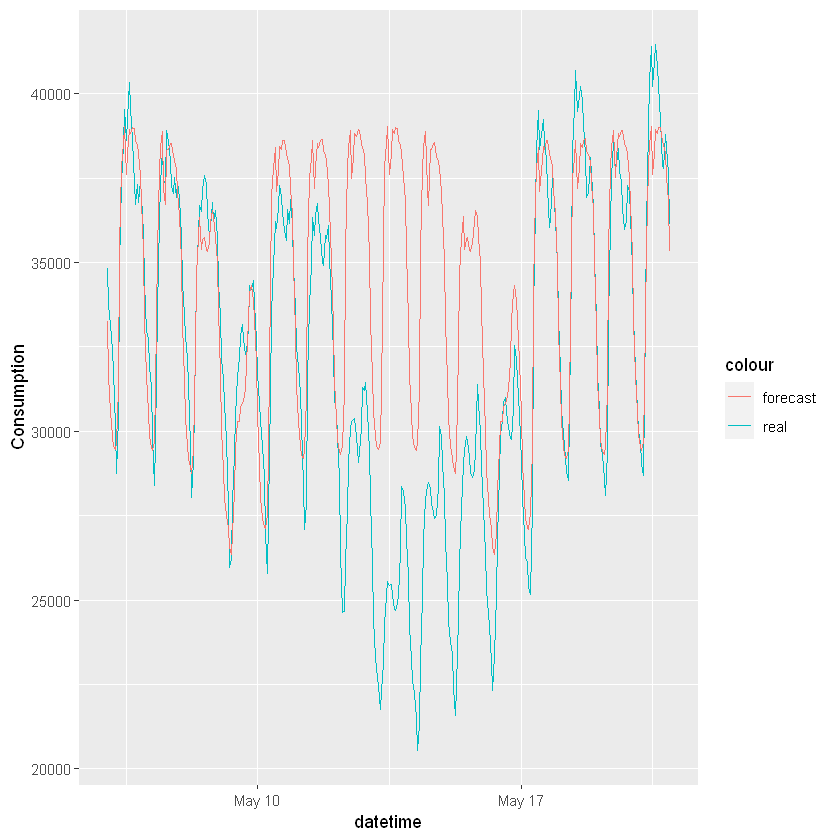

In [44]:
ggplot(test_set, aes(x=datetime)) + geom_line(aes(y=Consumption, color="real")) + geom_line(aes(y=forecast, color="forecast"))

Our forecasts seem well although some of them overpredict. The reason can be that these days are religious holiday in Turkey.

In [45]:
accu<-function(actual,forecast){
  n=length(actual)
  error=actual-forecast
  mean=mean(actual)
  sd=sd(actual)
  CV=sd/mean
  FBias=sum(error)/sum(actual)
  MAPE=sum(abs(error/actual))/n
  RMSE=sqrt(sum(error^2)/n)
  MAD=sum(abs(error))/n
  MADP=sum(abs(error))/sum(abs(actual))
  WMAPE=MAD/mean
  l=data.frame(n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE)
  return(l)
}

accu(test_set$Consumption, test_set$forecast)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
360,32019.35,4951.71,0.1546475,-0.07245524,0.1102898,4653.468,3074.231,0.09601168,0.09601168


## Conclusion

In this assignment, we tried to forecast 15 days of electricity consumption. Firstly, different types of seasonality were examined. Then, the data were decomposed. AR, MA, and ARMA models are built and the best one was chosen in order to forecast. Above, the error measurements could be seen. Although the model forecasted well, some points were overestimated due to the religious days.